In [98]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [99]:


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [100]:

word2Id_dict = dict(np.load('dictionary' + '/word2Id.npy'))
id2word_dict = dict(np.load('dictionary' + '/id2Word.npy'))
num_training_sample = len(pd.read_pickle('dataset' + '/text2ImgData.pkl'))

In [101]:
import random
VIS_ROWS = 8
VIS_COLS = 8

train_df = pd.read_pickle('dataset' + '/text2ImgData_withClipEmbeddings.pkl')
train_row_list = list(zip(train_df['ImagePath'], train_df['Captions'], train_df['Embeddings']))
sample_row_list = random.choices(train_row_list, k=VIS_ROWS)
sample_image_paths, sample_captions, sample_embeddings = zip(*sample_row_list)
sample_texts = [' '.join([id2word_dict[id] for id in caption_ids[0] if id2word_dict[id] != '<PAD>']) for caption_ids in sample_captions]
sample_embeddings = [embeddings[0] for embeddings in sample_embeddings]


In [102]:
import tensorflow as tf
import pandas as pd
import numpy as np

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3
BATCH_SIZE = 64
EMBEDDING_DIM = 768
Z_DIM = 128
NUM_SAMPLES = train_df.shape[0]

def training_data_generator(embeddings, image_path):
    # 1. 讀取與解碼圖片 
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 2. 截取圖片中間最大正方形區域並調整大小
    shape = tf.shape(img)
    height = shape[0]
    width = shape[1]
    new_side = tf.minimum(height, width)
    offset_height = (height - new_side) // 2
    offset_width = (width - new_side) // 2
    img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, new_side, new_side)

    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])


    # # Random Scale & Crop 
    # scalex = tf.random.uniform([], minval=1.0, maxval=1.05)
    # scaley = tf.random.uniform([], minval=1.0, maxval=1.05)
    # new_height = tf.cast(tf.cast(IMAGE_HEIGHT, tf.float32) * scaley, tf.int32)
    # new_width = tf.cast(tf.cast(IMAGE_WIDTH, tf.float32) * scalex, tf.int32)
    # img = tf.image.resize(img, size=[new_height, new_width])
    # img = tf.image.random_crop(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])

    # # Color Jitter
    # img = tf.image.random_brightness(img, max_delta=0.15)
    # img = tf.image.random_contrast(img, lower=0.85, upper=1.15)
    # img = tf.image.random_saturation(img, lower=0.85, upper=1.15)
    
    # Augmentation & Normalization 
    img = tf.image.random_flip_left_right(img)
    img = (img - 0.5) * 2.0
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    mask = tf.reduce_sum(tf.abs(embeddings), axis=1) > 0
    valid_embeddings = tf.boolean_mask(embeddings, mask)
    embedding = tf.random.shuffle(valid_embeddings)[0]

    return img, embedding

def dataset_generator(filename, batch_size, data_generator):
    # 讀取 pickle
    df = pd.read_pickle(filename)
    
    embeddings = df['Embeddings'].values 
    image_paths = df['ImagePath'].values

    max_embed_amount = max([len(embed) for embed in embeddings])

    # Padding Embeddings
    padded_embeddings = []
    for embed in embeddings:
        pad_amount = max_embed_amount - len(embed)
        if pad_amount > 0:
            pad_embed = np.zeros((pad_amount, embed.shape[1]))
            padded_embed = np.vstack([embed, pad_embed])
        else:
            padded_embed = embed
        padded_embeddings.append(padded_embed)
    embeddings = padded_embeddings
    embeddings = tf.cast(embeddings, tf.float32)

    
    dataset = tf.data.Dataset.from_tensor_slices(
        (embeddings, image_paths)
    )
    
    # Map 函式
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(image_paths)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [103]:
dataset = dataset_generator('dataset' + '/text2ImgData_withClipEmbeddings.pkl', BATCH_SIZE, training_data_generator)

In [104]:

print("=== Dataset Structure Check ===")

try:
    # 取得第一個 Batch
    image_batch, embeddings_batch = next(iter(dataset))

    print("成功讀取第一個 Batch。")
    print("-" * 30)
    
    # 檢查圖片 (Output 1)
    print("圖片 (Image Batch):")
    print(f"  Shape: {image_batch.shape} (Batch, Height, Width, Channel)")
    print(f"  DType: {image_batch.dtype}")
    
    # 檢查文字 Embedding (Output 2)
    print("\nEmbedding Batch:")
    print(f"  Shape: {embeddings_batch.shape} (Batch, Embedding Dimension)")
    print(f"  DType: {embeddings_batch.dtype}")

    # 驗證結構是否符合模型預期 (假設圖片 64x64x3, Embedding 128)
    expected_image_shape = [BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL]
    expected_embedding_dim = EMBEDDING_DIM

    if list(image_batch.shape) == expected_image_shape and embeddings_batch.shape[1] == expected_embedding_dim:
        print("\n數據結構符合預期 可以開始訓練了。")
    else:
        print("\n數據結構與模型預期不符 請檢查 IMAGE_HEIGHT, IMAGE_WIDTH, 或 EMBEDDING_DIM 設定。")

except Exception as e:
    print(f"讀取 Batch 失敗，請檢查錯誤：{e}")

=== Dataset Structure Check ===
成功讀取第一個 Batch。
------------------------------
圖片 (Image Batch):
  Shape: (64, 64, 64, 3) (Batch, Height, Width, Channel)
  DType: <dtype: 'float32'>

Embedding Batch:
  Shape: (64, 768) (Batch, Embedding Dimension)
  DType: <dtype: 'float32'>

數據結構符合預期 可以開始訓練了。


In [105]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class SpectralNormalization(layers.Wrapper):
    def __init__(self, layer, iteration=1, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self.iteration = iteration

    def build(self, input_shape):
        if not self.layer.built:
            self.layer.build(input_shape)
        
        # 獲取權重 (kernel 或 embeddings)
        if hasattr(self.layer, 'kernel'):
            self.w = self.layer.kernel
        else:
            raise AttributeError("Layer must have a 'kernel' weight for SN.")

        self.w_shape = self.w.shape.as_list()
        # u 向量的形狀: (1, 輸出維度)
        self.u_shape = (1, self.w_shape[-1])
        
        # 定義 u 向量
        self.u = self.add_weight(
            name='u',
            shape=self.u_shape,
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False, # u 是不可訓練變數
            dtype=self.w.dtype
        )
        self.built = True

    def _get_spectral_normalized_kernel(self, training):
        w_mat = tf.reshape(self.w, [-1, self.w_shape[-1]])

        if training:
            # 訓練時：Power Iteration 估算 u, 並更新 self.u
            u_hat = self.u
            v_hat = None
            for _ in range(self.iteration):
                # v_hat = normalized(u_hat * W^T)
                v_hat = tf.nn.l2_normalize(tf.matmul(u_hat, w_mat, transpose_b=True))
                # u_hat = normalized(v_hat * W)
                u_hat = tf.nn.l2_normalize(tf.matmul(v_hat, w_mat))
            
            # 更新 self.u (只在訓練時)
            self.u.assign(u_hat)
            
            # 計算 sigma = v_hat * W * u_hat^T (實際的譜範數)
            sigma = tf.matmul(tf.matmul(v_hat, w_mat), u_hat, transpose_b=True)
            sigma = tf.reshape(sigma, [])
        
        else:
            # 推理時：使用保存的 self.u 估算 sigma (無需迭代)
            v = tf.nn.l2_normalize(tf.matmul(self.u, w_mat, transpose_b=True))
            sigma = tf.matmul(tf.matmul(v, w_mat), self.u, transpose_b=True)
            sigma = tf.reshape(sigma, [])
            
        # 計算歸一化後的權重
        return self.w / sigma

    def call(self, inputs, training=False):
        # 1. 獲取正規化後的權重 Tensor
        w_sn = self._get_spectral_normalized_kernel(training)
        
        # 2. 判斷底層是什麼層，並手動執行前向傳播
        if isinstance(self.layer, tf.keras.layers.Conv2D):
            # 執行卷積
            outputs = self.layer.convolution_op(inputs, w_sn)
            # 加 Bias
            if self.layer.use_bias:
                outputs = tf.nn.bias_add(outputs, self.layer.bias, data_format='NHWC')
                
        elif isinstance(self.layer, tf.keras.layers.Dense):
            # 執行矩陣乘法
            outputs = tf.matmul(inputs, w_sn)
            # 加 Bias
            if self.layer.use_bias:
                outputs = tf.nn.bias_add(outputs, self.layer.bias)
                
        else:
            # 如果是其他層，通常不需要 SN (但這裡為避免錯誤，回退到原始呼叫，會丟失 SN 效果)
            return self.layer(inputs)
            
        # 3. 執行激活函數 (如果底層層次有定義)
        if hasattr(self.layer, 'activation') and self.layer.activation is not None:
            outputs = self.layer.activation(outputs)
            
        return outputs

In [106]:
# 這是條件批次正規化層，將文字Embedding (y) 注入到 Batch Norm 的參數中
class CondBatchNorm(layers.Layer):
    def __init__(self, **kwargs):
        super(CondBatchNorm, self).__init__(**kwargs)
        # 不對原始 BN 執行中心化或縮放 (center=False, scale=False)
        self.bn = layers.BatchNormalization(center=False, scale=False)

    def build(self, input_shape):
        feature_shape = input_shape[0] # (B, H, W, C)
        # text_emb_shape = input_shape[1] # (B, EMB_DIM)
        
        self.channel = feature_shape[-1]
        
        # 用來從文字 Embedding 預測 gamma (Scale) 和 beta (Shift)
        self.gamma_dense = layers.Dense(self.channel, name='gamma_dense')
        self.beta_dense = layers.Dense(self.channel, name='beta_dense')
        super(CondBatchNorm, self).build(input_shape)

    def call(self, inputs, training=True):
        x, y = inputs # x: 圖片特徵, y: 文字Embedding
        
        # 1. 計算 BN 輸出 (只執行正規化)
        norm_x = self.bn(x, training=training)

        # 2. 從文字 Embedding 計算 gamma (scale) 和 beta (shift)
        gamma = self.gamma_dense(y)
        beta = self.beta_dense(y)

        # 3. 調整維度以進行廣播 (Broadcasting): (B, C) -> (B, 1, 1, C)
        channel_dim = tf.shape(gamma)[-1]
        gamma = tf.reshape(gamma, (-1, 1, 1, channel_dim))
        beta = tf.reshape(beta, (-1, 1, 1, channel_dim))

        # 4. 執行條件化 BigGAN 風格：(1 + gamma) * BN(x) + beta
        return norm_x * (1 + gamma) + beta

In [107]:
def res_block(x, filters, downsample=False, upsample=False, use_sn=False):
    """
    通用 ResBlock: 
    - use_sn=True 用於 Discriminator
    - use_sn=False 用於 Generator
    """
    input_layer = x
    
    # === Main Path ===
    if upsample:
        x = layers.UpSampling2D()(x)
        
    # 第一層 Conv
    conv1 = layers.Conv2D(filters, 3, padding='same')
    if use_sn: conv1 = SpectralNormalization(conv1)
    x = conv1(x)
    
    # Generator 用 BN, Discriminator 不用 (或用 LayerNorm)
    if not use_sn: x = layers.BatchNormalization()(x) 
    x = layers.LeakyReLU()(x)

    # 第二層 Conv
    conv2 = layers.Conv2D(filters, 3, padding='same')
    if use_sn: conv2 = SpectralNormalization(conv2)
    x = conv2(x)
    
    if not use_sn: x = layers.BatchNormalization()(x)
    
    if downsample:
        x = layers.AveragePooling2D(pool_size=(2, 2))(x)

    # === Shortcut Path (捷徑) ===
    if upsample:
        input_layer = layers.UpSampling2D(size=(2, 2))(input_layer)
    
    # 如果通道數改變或需要 Downsample，Shortcut 需要 1x1 Conv 調整
    if downsample or input_layer.shape[-1] != filters:
        shortcut_conv = layers.Conv2D(filters, 1, padding='same')
        if use_sn: shortcut_conv = SpectralNormalization(shortcut_conv)
        input_layer = shortcut_conv(input_layer)
        
    if downsample:
        input_layer = layers.AveragePooling2D(pool_size=(2, 2))(input_layer)

    return layers.Add()([x, input_layer])

In [108]:
# 這是專用於 Generator 的條件殘差區塊，使用 CondBatchNorm
def cond_res_block(x, y, n_filters, upsample=False, name='cond_res_block', use_sn=False):
    x0 = x
    
    with tf.name_scope(name):
        
        # 1. Branch 1
        x = CondBatchNorm(name=f'{name}_bn1')([x, y]) # 使用 CondBatchNorm
        x = layers.LeakyReLU()(x)
        
        if upsample:
            x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        
        conv1 = layers.Conv2D(n_filters, 3, padding='same', name=f'{name}_conv1')
        if use_sn:
            x = SpectralNormalization(conv1)(x)
        else:
            x = conv1(x)

        # 2. Branch 2
        x = CondBatchNorm(name=f'{name}_bn2')([x, y]) # 使用 CondBatchNorm
        x = layers.LeakyReLU()(x)
        
        conv2 = layers.Conv2D(n_filters, 3, padding='same', name=f'{name}_conv2')
        if use_sn:
            x = SpectralNormalization(conv2)(x)
        else:
            x = conv2(x)
            
        # 3. Short-cut/Residual Connection 
        # 如果維度不匹配 (通道數或 UpSample) 需要 1x1 卷積
        if x0.shape[-1] != n_filters or upsample:
            conv_sc = layers.Conv2D(n_filters, 1, padding='same', name=f'{name}_sc_conv')
            if upsample:
                x0 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x0)
            
            if use_sn:
                x0 = SpectralNormalization(conv_sc)(x0) # D 不使用 SN
            else:
                x0 = conv_sc(x0)

        # 4. 相加
        return x + x0

In [109]:
# 修改後的 build_generator 函數
def build_generator(z_dim, emb_dim, n_filters=256, use_sn=False):
    # Inputs
    z_input = layers.Input(shape=(z_dim,), name='z_input')
    text_input = layers.Input(shape=(emb_dim,), name='text_input') # 文字 Embedding
    
    x = layers.Dense(4 * 4 * n_filters)(z_input)
    x = layers.Reshape((4, 4, n_filters))(x)
    
    # 將文字 Embedding 賦值給 y，作為 CondBatchNorm 的條件輸入
    y = text_input 
    
    # 2. CondResBlocks (升採樣) - 現在使用 cond_res_block
    # 4x4 -> 8x8
    x = cond_res_block(x, y, n_filters, upsample=True, name='gen_block1', use_sn=use_sn)
    
    # 8x8 -> 16x16
    x = cond_res_block(x, y, n_filters // 2, upsample=True, name='gen_block2', use_sn=use_sn)
    
    # 16x16 -> 32x32
    x = cond_res_block(x, y, n_filters // 4, upsample=True, name='gen_block3', use_sn=use_sn)
    
    # 32x32 -> 64x64
    x = cond_res_block(x, y, n_filters // 8, upsample=True, name='gen_block4', use_sn=use_sn)

    # 3. 輸出層
    # 最後一次 CondBatchNorm
    x = CondBatchNorm(name='final_bn')([x, y]) 
    x = layers.LeakyReLU()(x)
    
    # 輸出使用 tanh 激活函數，將像素值約束在 [-1, 1]
    x = layers.Conv2D(3, 3, padding='same', activation='tanh', name='output_conv')(x)
    
    return Model(inputs=[z_input, text_input], outputs=x, name='generator')

In [110]:
def build_discriminator(img_shape=(64, 64, 3), embedding_dim=768):
    img_input = layers.Input(shape=img_shape, name="image_input")
    text_input = layers.Input(shape=(embedding_dim,), name="text_input")
    
    # --- 圖片處理主幹 (Backbone) ---
    x = SpectralNormalization(layers.Conv2D(64, 3, padding='same'))(img_input)
    x = layers.LeakyReLU(0.2)(x)
    
    # 下採樣 ResBlocks
    x = res_block(x, 128, downsample=True, use_sn=True) # 32x32
    x = res_block(x, 256, downsample=True, use_sn=True) # 16x16
    x = res_block(x, 512, downsample=True, use_sn=True) # 8x8
    x = res_block(x, 512, downsample=True, use_sn=True) # 4x4
    
    x = layers.LeakyReLU()(x)

    
    # 使用 Lambda 實作 Global Sum Pooling (解決之前的 AttributeError)
    phi = layers.Lambda(lambda t: tf.reduce_sum(t, axis=[1, 2]))(x) # [Batch, 513]
    
    # --- Projection Logic (投影機制) ---
    # 1. 來自圖片本身的判斷分數
    output_content = SpectralNormalization(layers.Dense(1))(phi)
    
    # 2. 來自圖文匹配的判斷分數 (Inner Product)
    text_proj = SpectralNormalization(layers.Dense(512))(text_input) 
    
    # [修正點]：使用 layers.Dot 來計算內積，而不是 tf.reduce_sum
    # axes=1 代表沿著特徵維度 (512) 做點積，輸出為 [Batch, 1]
    output_projection = layers.Dot(axes=1)([phi, text_proj])
    
    # 總分 = 內容分數 + 匹配分數
    final_output = layers.Add()([output_content, output_projection])
    
    return Model([img_input, text_input], final_output, name="Discriminator")

In [ ]:
import tensorflow as tf

def DiffAugment(x, policy='translation,cutout'):
    if 'translation' in policy:
        x = rand_translation(x)
        
    if 'cutout' in policy:
        x = rand_cutout(x)
        
    return x


# === 2. 平移增強 (Translation) ===
def rand_translation(x, ratio=0.15):
    batch_size = tf.shape(x)[0]
    img_h = tf.shape(x)[1]
    img_w = tf.shape(x)[2]
    
    # 計算要平移的像素量
    shift_h = tf.cast(tf.cast(img_h, tf.float32) * ratio, tf.int32)
    shift_w = tf.cast(tf.cast(img_w, tf.float32) * ratio, tf.int32)
    
    # 先做 Padding (填補 0 或反射)
    x = tf.pad(x, [[0, 0], [shift_h, shift_h], [shift_w, shift_w], [0, 0]], mode='REFLECT')
    
    # 再隨機 Crop 回原本大小
    # tf.image.random_crop 會對整個 Batch 做同樣的裁切，這對 DiffAugment 來說是可接受的
    # 但若要每個 Sample 不同，寫法會更複雜。這裡採用標準 TF 做法。
    x = tf.image.random_crop(x, [batch_size, img_h, img_w, 3])
    
    return x

# === 3. 遮擋增強 (Cutout) ===
def rand_cutout(x, ratio=0.2):
    batch_size = tf.shape(x)[0]
    img_h = tf.shape(x)[1]
    img_w = tf.shape(x)[2]
    
    cutout_size_h = tf.cast(tf.cast(img_h, tf.float32) * ratio, tf.int32)
    cutout_size_w = tf.cast(tf.cast(img_w, tf.float32) * ratio, tf.int32)
    
    # 隨機決定 cutout 的中心點
    offset_h = tf.random.uniform([batch_size, 1, 1], minval=0, maxval=img_h + (1 - cutout_size_h % 2), dtype=tf.int32)
    offset_w = tf.random.uniform([batch_size, 1, 1], minval=0, maxval=img_w + (1 - cutout_size_w % 2), dtype=tf.int32)
    
    # 建立 Grid
    grid_batch, grid_h, grid_w = tf.meshgrid(
        tf.range(batch_size, dtype=tf.int32),
        tf.range(img_h, dtype=tf.int32),
        tf.range(img_w, dtype=tf.int32),
        indexing='ij'
    )
    
    # 建立 Mask (在 cutout 範圍內為 False，保留區域為 True)
    mask_h = (grid_h >= offset_h - cutout_size_h // 2) & (grid_h < offset_h + cutout_size_h // 2)
    mask_w = (grid_w >= offset_w - cutout_size_w // 2) & (grid_w < offset_w + cutout_size_w // 2)
    mask = ~(mask_h & mask_w) # 取反，要保留的地方是 1
    
    mask = tf.cast(mask, x.dtype)
    mask = tf.expand_dims(mask, -1) # 擴展 Channel 維度
    
    # 應用 Mask
    x = x * mask
    return x

In [112]:
def update_ema_weights(ema_model, current_model, beta):
    ema_weights = ema_model.get_weights()
    current_weights = current_model.get_weights()
    
    new_weights = []
    for ema_w, curr_w in zip(ema_weights, current_weights):
        # 公式: New = Beta * Old + (1 - Beta) * Current
        new_w = beta * ema_w + (1 - beta) * curr_w
        new_weights.append(new_w)
        
    ema_model.set_weights(new_weights)

In [113]:
# 初始化模型與優化器
g_model = build_generator(Z_DIM, EMBEDDING_DIM)
d_model = build_discriminator()
ema_g_model = build_generator(Z_DIM, EMBEDDING_DIM)

In [114]:


# 注意 Beta 參數 (SNGAN 標準設定)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.0, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)

# Hinge Loss
def discriminator_loss(real_logits, fake_logits):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return -tf.reduce_mean(fake_logits)

# 訓練步驟 (使用 tf.function 加速)
@tf.function
def train_d_step(real_images, text_embeddings, batch_size):
    noise = tf.random.normal([batch_size, 128])
    
    # 製作 "錯誤的文字敘述" (將原本的 Batch 順序打亂)
    mismatched_embeddings = tf.roll(text_embeddings, shift=1, axis=0)
    
    with tf.GradientTape() as tape:
        fake_images = g_model([noise, text_embeddings], training=True)
        fake_images = DiffAugment(fake_images, policy='translation,cutout')
        real_images = DiffAugment(real_images, policy='translation,cutout')
        # 1. 真圖 + 對的文字 -> 應該判斷為真 (Score > 0)
        real_logits = d_model([real_images, text_embeddings], training=True)
        
        # 2. 假圖 + 對的文字 -> 應該判斷為假 (Score < 0)
        fake_logits = d_model([fake_images, text_embeddings], training=True)
        
        # 3. [新增] 真圖 + 錯的文字 -> 應該判斷為假 (Score < 0)
        wrong_text_logits = d_model([real_images, mismatched_embeddings], training=True)
        
        # 修改 Loss 計算
        # Real Loss
        d_loss_real = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
        # Fake Loss (包含假圖 + 錯字)
        d_loss_fake = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
        d_loss_wrong = tf.reduce_mean(tf.nn.relu(1.0 + wrong_text_logits))
        
        d_loss = d_loss_real + (d_loss_fake + d_loss_wrong) * 0.5 # 平均一下 fake 部分
        
    d_grads = tape.gradient(d_loss, d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, d_model.trainable_variables))
    return d_loss

@tf.function
def train_g_step(text_embeddings, batch_size):
    noise1 = tf.random.normal([batch_size, 128])
    
    with tf.GradientTape() as tape:
        # 生成兩組圖片
        fake_images1 = g_model([noise1, text_embeddings], training=True)
        
        # 增強處理 (保持原本邏輯)
        fake_images1_aug = DiffAugment(fake_images1, policy='translation,cutout')
        
        # 計算原本的 GAN Loss
        fake_logits = d_model([fake_images1_aug, text_embeddings], training=True)
        g_loss_original = generator_loss(fake_logits)
        
        # 總 Loss (lambda_coeff 可以設 0.1 ~ 1.0)
        g_loss = g_loss_original
        
    g_grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, g_model.trainable_variables))
    return g_loss



In [115]:
CHECKPOINT_DIR = './checkpoints/demo/'
epoch_tracker = tf.Variable(0, trainable=False, dtype=tf.int64)


# 定義 Checkpoint (用於儲存模型)
checkpoint_dir = CHECKPOINT_DIR
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=g_model,
                                 discriminator=d_model,
                                 epoch=epoch_tracker)

In [116]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
print("Checkpoint restored.")

Checkpoint restored.


In [117]:
if not os.path.exists('samples/demo'):
    os.makedirs('samples/demo')

In [118]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [119]:
# === 主訓練迴圈 ===
# 假設 dataset 已經是 tf.data.Dataset 物件
# dataset = ... (載入 Oxford-102 並 resize 到 64x64)

from tqdm import tqdm
import time


epochs = 10000
n_dis = 2  # Discriminator 更新頻率
noise = tf.random.normal([VIS_COLS, Z_DIM])
noise_matrix = tf.tile(noise, [VIS_ROWS, 1])
embedding_matrix = tf.convert_to_tensor(sample_embeddings, dtype=tf.float32)
embedding_matrix = tf.repeat(embedding_matrix, repeats=VIS_COLS, axis=0)

pbar = tqdm(range(epoch_tracker.numpy(), epochs), total=epochs, desc=f"Training {epochs} Epochs")
for epoch in pbar:
    epoch_tracker.assign(epoch + 1)
    
    g_loss_total = 0.0
    d_loss_total = 0.0
    g_step_count = 0
    d_step_count = 0
    g_loss = 0.0
    d_loss = 0.0
    start = time.time()
    
    for i, batch in enumerate(dataset):
        images_batch, embeddings_batch = batch
        batch_size = tf.shape(images_batch)[0]
        
        # 1. 訓練 Discriminator
        d_loss = train_d_step(images_batch, embeddings_batch, batch_size)
        d_loss_total += d_loss
        d_step_count += 1
        pbar.set_postfix({'G Loss': f'{g_loss:.4f}', 'D Loss': f'{d_loss:.4f}'})
        
        # 2. 訓練 Generator (每 n_dis 次才執行一次)
        if i % n_dis == 0:
            g_loss = train_g_step(embeddings_batch, batch_size)
            g_loss_total += g_loss
            g_step_count += 1
            pbar.set_postfix({'G Loss': f'{g_loss:.4f}', 'D Loss': f'{d_loss:.4f}'})

            # 3. 更新 EMA Generator 權重
            update_ema_weights(ema_g_model, g_model, beta=0.99)

        
    if (epoch + 1) % 5 == 0:
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                    g_loss_total/g_step_count,
                                                                    d_loss_total/d_step_count))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))

        # save the model
        checkpoint.save(file_prefix = checkpoint_prefix + '-{}'.format(epoch+1))
    
        # Visualization 
        fake_image = g_model([noise_matrix, embedding_matrix], training=False)
        ema_fake_image = ema_g_model([noise_matrix, embedding_matrix], training=False)
        save_images(fake_image, [VIS_ROWS, VIS_COLS], 'samples/demo/train_{:02d}.jpg'.format(epoch))
        save_images(ema_fake_image, [VIS_ROWS, VIS_COLS], 'samples/demo/train_{:02d}_ema.jpg'.format(epoch))

Training 10000 Epochs:   0%|          | 4/10000 [02:19<75:54:53, 27.34s/it, G Loss=2.0036, D Loss=0.4667]

Epoch 1005, gen_loss: 2.7103, disc_loss: 0.3825
Time for epoch 1005 is 26.3353 sec


Training 10000 Epochs:   0%|          | 9/10000 [04:31<73:37:48, 26.53s/it, G Loss=1.9316, D Loss=0.3038]

Epoch 1010, gen_loss: 2.4868, disc_loss: 0.3963
Time for epoch 1010 is 26.3901 sec


Training 10000 Epochs:   0%|          | 14/10000 [06:41<72:26:56, 26.12s/it, G Loss=3.4142, D Loss=0.3529]

Epoch 1015, gen_loss: 2.8209, disc_loss: 0.3884
Time for epoch 1015 is 25.2445 sec


Training 10000 Epochs:   0%|          | 19/10000 [08:47<70:27:17, 25.41s/it, G Loss=2.1295, D Loss=0.4345]

Epoch 1020, gen_loss: 3.1313, disc_loss: 0.3805
Time for epoch 1020 is 25.2208 sec


Training 10000 Epochs:   0%|          | 24/10000 [10:54<70:04:33, 25.29s/it, G Loss=1.0244, D Loss=0.5203]

Epoch 1025, gen_loss: 2.8636, disc_loss: 0.3843
Time for epoch 1025 is 25.2798 sec


Training 10000 Epochs:   0%|          | 29/10000 [13:01<70:02:23, 25.29s/it, G Loss=1.6665, D Loss=0.5523]

Epoch 1030, gen_loss: 2.5068, disc_loss: 0.3770
Time for epoch 1030 is 25.9057 sec


Training 10000 Epochs:   0%|          | 34/10000 [15:09<70:43:31, 25.55s/it, G Loss=3.2883, D Loss=0.2381]

Epoch 1035, gen_loss: 3.0256, disc_loss: 0.3745
Time for epoch 1035 is 25.3905 sec


Training 10000 Epochs:   0%|          | 39/10000 [17:16<70:19:38, 25.42s/it, G Loss=2.8389, D Loss=0.1905]

Epoch 1040, gen_loss: 2.7063, disc_loss: 0.3600
Time for epoch 1040 is 25.3628 sec


Training 10000 Epochs:   0%|          | 44/10000 [19:23<70:13:39, 25.39s/it, G Loss=3.5346, D Loss=0.3892]

Epoch 1045, gen_loss: 2.8181, disc_loss: 0.3640
Time for epoch 1045 is 25.3322 sec


Training 10000 Epochs:   0%|          | 49/10000 [21:30<70:15:14, 25.42s/it, G Loss=0.7181, D Loss=0.4489]

Epoch 1050, gen_loss: 2.9117, disc_loss: 0.3611
Time for epoch 1050 is 25.3659 sec


Training 10000 Epochs:   1%|          | 54/10000 [23:37<70:12:29, 25.41s/it, G Loss=2.0533, D Loss=0.4276]

Epoch 1055, gen_loss: 2.7219, disc_loss: 0.3641
Time for epoch 1055 is 25.3354 sec


Training 10000 Epochs:   1%|          | 59/10000 [25:45<70:07:25, 25.39s/it, G Loss=2.8042, D Loss=0.3999]

Epoch 1060, gen_loss: 2.6698, disc_loss: 0.3710
Time for epoch 1060 is 25.3571 sec


Training 10000 Epochs:   1%|          | 64/10000 [27:52<70:04:57, 25.39s/it, G Loss=2.2799, D Loss=0.3227]

Epoch 1065, gen_loss: 2.9426, disc_loss: 0.3478
Time for epoch 1065 is 25.7198 sec


Training 10000 Epochs:   1%|          | 67/10000 [28:55<71:29:01, 25.91s/it, G Loss=2.1391, D Loss=0.2929]


KeyboardInterrupt: 

In [ ]:
# 1. 先建立模型實例 (必須和訓練時的架構一模一樣)
# 這裡假設您的 Generator Class 已經定義好了
test_generator = build_generator(Z_DIM, EMBEDDING_DIM)

# 2. 建構模型 (Build Model)
# Keras 需要先跑一次假資料來確定 Input Shape，才能載入權重
dummy_text = tf.random.normal([1, EMBEDDING_DIM]) # 根據您的 EMBEDDING_DIM
dummy_noise = tf.random.normal([1, Z_DIM]) # 根據您的 Z_DIM
_ = test_generator([dummy_noise, dummy_text], training=True)

# 3. 載入權重
checkpoint = tf.train.Checkpoint(generator=test_generator)
checkpoint.restore('checkpoints/demo/ckpt-905-181')

print("Generator 權重載入成功！")

Generator 權重載入成功！


In [ ]:
test_data = pd.read_pickle('./dataset/testData_withClipEmbeddings.pkl')
embeddings = test_data['Embeddings'].values
TEST_BATCH_SIZE = 64
NUM_TEST = len(embeddings)
EPOCH_TEST = int(NUM_TEST / TEST_BATCH_SIZE)
test_data.head()


,ID,Captions,Embeddings
0,6735,"[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ...","[-0.45477903, 1.6527942, -1.1516384, -0.003386..."
1,6740,"[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6...","[-0.73496807, 0.16627079, -0.5422537, -0.86717..."
2,6746,"[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5...","[0.14433706, -0.73302346, -0.87360823, -0.6628..."
3,6759,"[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56...","[-1.1320665, 0.43853867, -0.35618687, -1.24536..."
4,6762,"[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427...","[-1.305689, -0.67254734, 0.56224334, -0.329145..."


In [ ]:
def testing_dataset_generator(filename, batch_size):
    # 讀取 pickle
    df = pd.read_pickle(filename)
    
    embeddings = np.stack(df['Embeddings'].values)
    embeddings = tf.cast(embeddings, tf.float32)
    ids = df['ID'].values


    
    dataset = tf.data.Dataset.from_tensor_slices(
        (embeddings, ids)
    )
    
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
testing_dataset = testing_dataset_generator(filename="dataset/testData_withClipEmbeddings.pkl", batch_size=TEST_BATCH_SIZE)

In [ ]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [ ]:
def inference(dataset, generator_):
    
    
    step = 0
    start = time.time()
    for embeddings, idx in dataset:
        sample_size = TEST_BATCH_SIZE
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, Z_DIM)).astype(np.float32)
        sample_seed = tf.convert_to_tensor(sample_seed)
        sample_size = embeddings.shape[0]
        sample_seed = sample_seed[:sample_size]
        if step > EPOCH_TEST:
            break
        
        fake_image = generator_([sample_seed, embeddings], training=False)
        step += 1
        for i in range(fake_image.shape[0]):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [ ]:
inference(testing_dataset, ema_g_model)

Time for inference is 0.7792 sec


In [ ]:
for row in test_data.head(5).itertuples():
    print(row.ID)
    text = ' '.join([id2word_dict[id] for id in row.Captions if id2word_dict[id] != '<PAD>'])
    print(text)

6735
this white and purple flower has fragile petals and soft stamens
6740
this flower has four large wide pink petals with white centers and vein like markings
6746
a flower with broad white and pink ribbed petals and yellow stamen
6759
one prominet pistil with alarger stigam and many stamens with anthers
6762
leaves are green in color petals are light pink in color


In [ ]:
print(len(os.listdir('./inference/demo/')))  # 應該和 test_data 的數量相同
print(len(test_data))  # 應該和 test_data 的數量相同

819
819


In [ ]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = './inference/demo/inference_{:04d}.jpg'.format(i)
        fake_iamge = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')

flower with white long white petals and very long purple stamen 
this medium white flower has rows of thin blue petals and thick stamen 
this flower is white and purple in color with petals that are oval shaped 
this flower is pink and yellow in color with petals that are oval shaped 
the flower has a large bright orange petal with pink anther 
the flower shown has a smooth white petal with patches of yellow as well 
white petals that become yellow as they go to the center where there is an orange stamen 
this flower has bright red petals with green pedicel as its main features 
this flower has the overlapping yellow petals arranged closely toward the center 
this flower has green sepals surrounding several layers of slightly ruffled pink petals 
the pedicel on this flower is purple with a green sepal and rose colored petals 
this white flower has connected circular petals with yellow stamen 
the flower has yellow petals overlapping each other and are yellow in color 
this flower has n

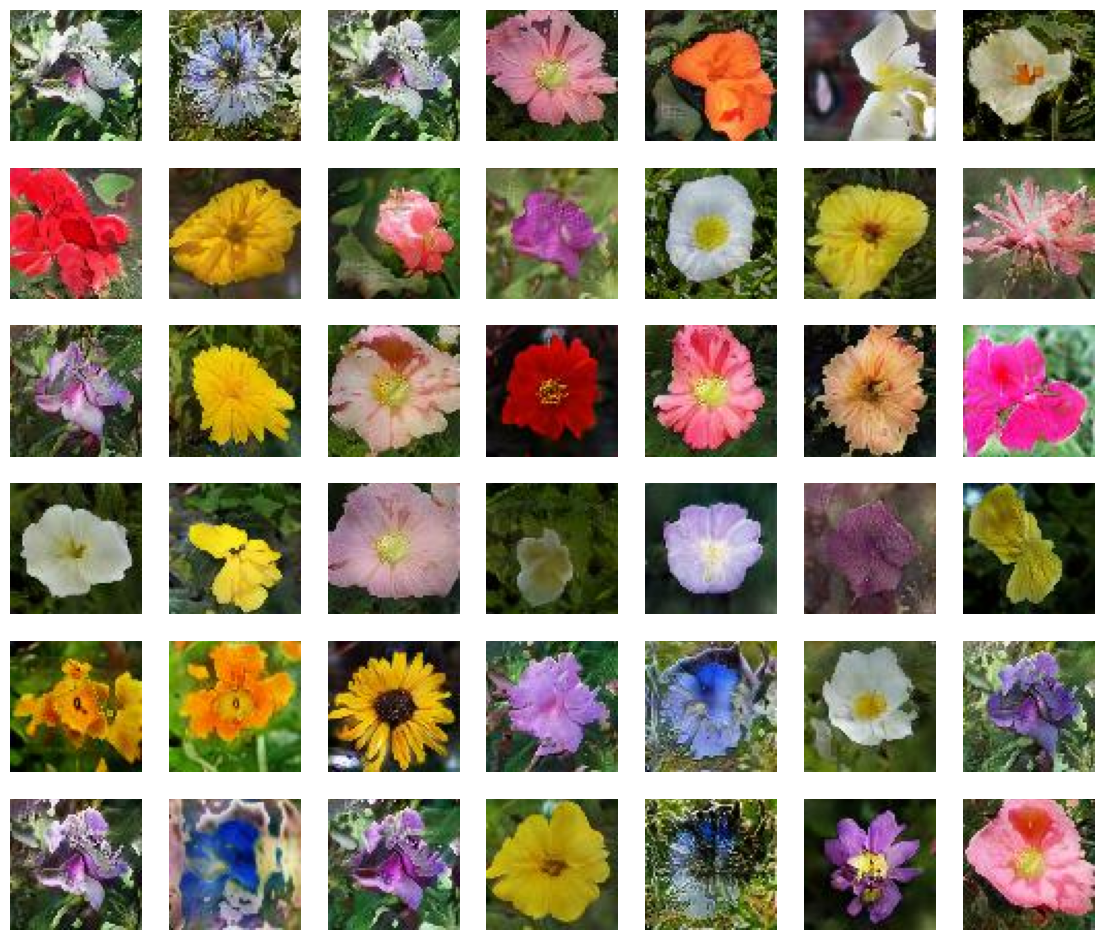

In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
random_idx = [23, 216, 224, 413, 713, 859, 876, 974, 1177, 1179, 1241, 2169, 2196, 2237, 
              2356, 2611, 2621, 2786, 2951, 2962, 3145, 3255, 3327, 3639, 3654, 3927, 4262, 
              4321, 4517, 5067, 5147, 5955, 6167, 6216, 6410, 6413, 6579, 6584, 6804, 6988, 
              7049, 7160]

visualize(random_idx)

this flower is red in color with petals that are rounded 
this flower has bright purple petals that appear to be independent of each other 
this flower is white and yellow in color with petals that are rounded at the endges 
this flower has a wrinkled petal that is white with green veins 
this flower is rose like with overlapping pink petals and a green pedicel 
this flower has a bright pink coloring with white around the edges and in the center 
this flower is pink and orange in color with petals that are drooping down 
this flower has petals that are pink with purple dots 
the petals of this flower are pink with green stamen 
what are the two different colors that are present on the petals of these flowers 
this flower has a lot of small white petals and no visible stigma 
this flower has petals that are red with yellow stigma 
this flower has a bright yellow center surrounded by deep indigo petals which are heart shaped 
this flower has yellow pistil and small red petals as its main

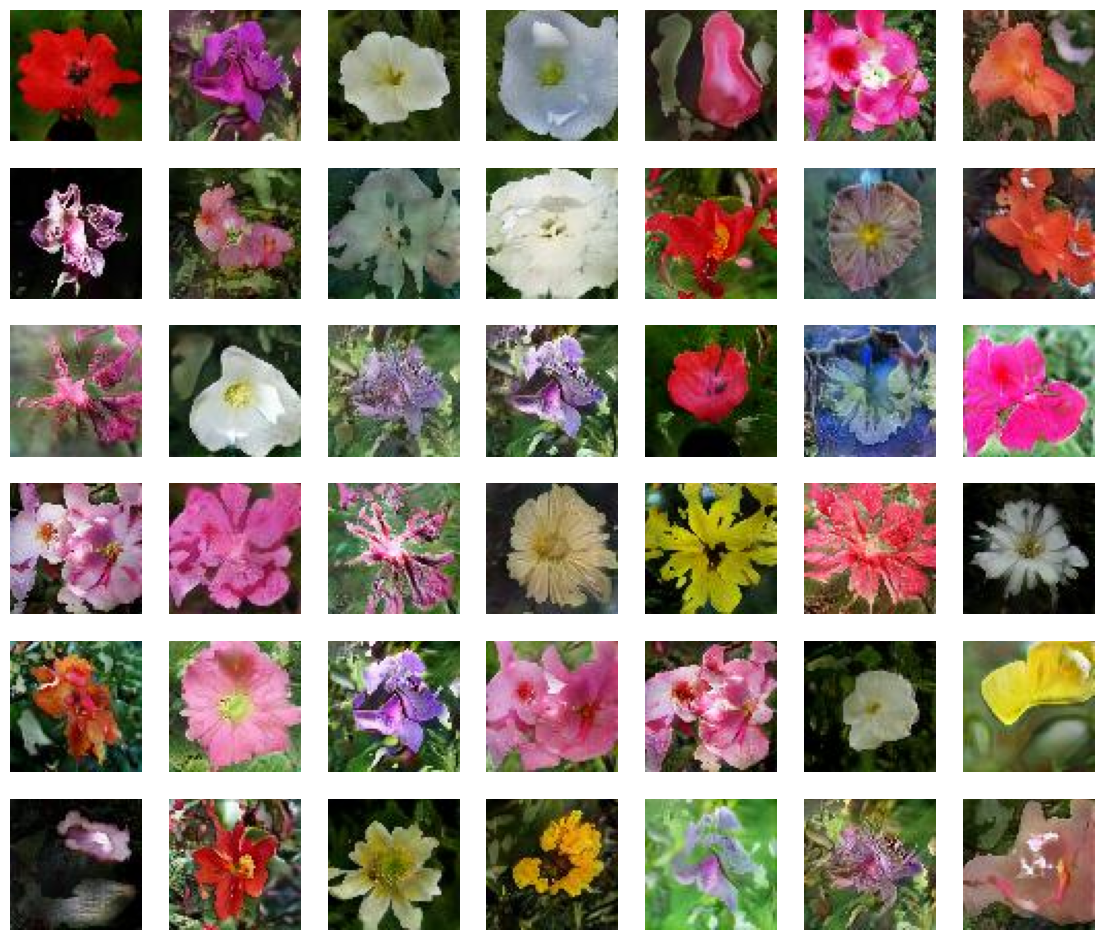

In [ ]:
from pathlib import Path
DATA_PATH = './inference/demo/'
img_path = Path(DATA_PATH).glob('*.jpg')
img_path = [str(path.resolve()) for path in img_path]
img_path = np.asarray(img_path)

idx = np.random.randint(len(captions), size=42)
idx.sort()

random_idx = []
for each in idx:
    # 提取文件名（僅最後一部分）
    filename = Path(img_path[each]).name  # 使用 pathlib 提取文件名
    # 去掉文件名中的 'inference_' 和 '.jpg'，並轉換為整數
    num = int(filename.replace('inference_', '').replace('.jpg', ''))
    random_idx.append(num)

visualize(random_idx)